<a href="https://colab.research.google.com/github/boykoot01/TM10007_ML_Project/blob/main/Final_Group15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group 15, dataset 3 \
TM10007 Machine Learning \
April 16th 2024 \
Dido Curwiel, Pim Steens, Cathelijne van der Zwan, Boy Koot**


In [1]:
# Git clone github
!git clone https://github.com/jveenland/TM10007_ML.git

Cloning into 'TM10007_ML'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 87 (delta 31), reused 80 (delta 30), pack-reused 0
Receiving objects: 100% (87/87), 67.99 MiB | 22.72 MiB/s, done.
Resolving deltas: 100% (31/31), done.


### **Import packages**

In [3]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from google.colab import drive
from TM10007_ML.worcgist.load_data import load_data
from sklearn import datasets as ds

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import RFECV
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel, sigmoid_kernel, laplacian_kernel, cosine_similarity, manhattan_distances
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from itertools import cycle
from scipy import interp




### **Load data**

In [4]:
data = load_data()

#replace labels
y_labels=data.pop('label').replace({'GIST': 1, 'non-GIST': 0})
X_target=data

### **Check data size and check for NaN values**

In [5]:
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data.isna().sum().sum())

The number of samples: 246
The number of columns: 493
0


### **Make train-test split**

In [ ]:
# Split the dataset in train and test part
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_target, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

### **Apply standard scaling**

In [ ]:
#Scale the dataset
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Perform PCA**

n_components: 21


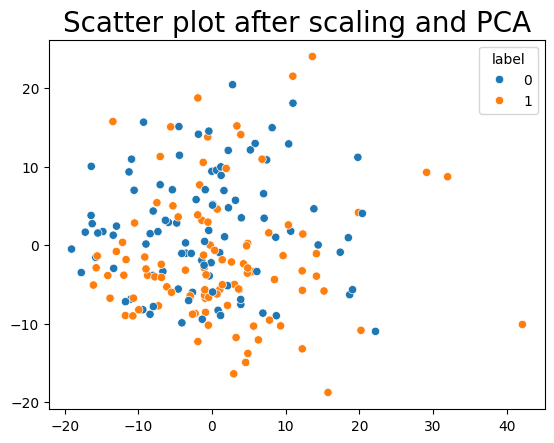

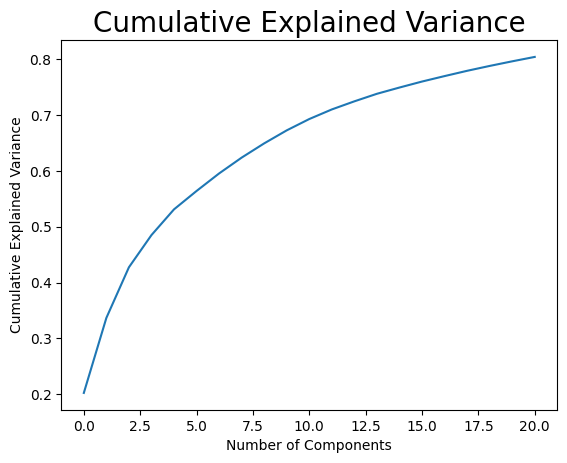

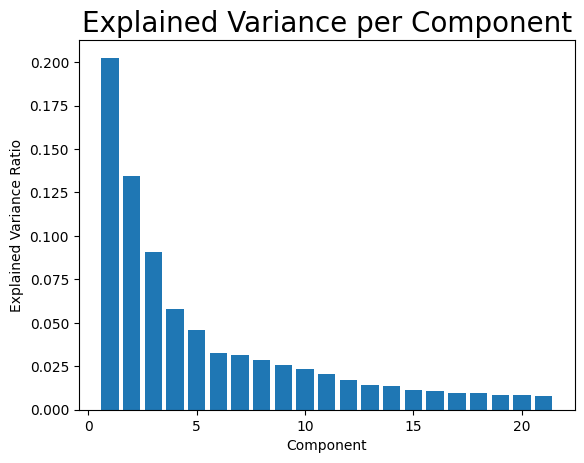

In [ ]:
#determening number of components: number of components where the cumulative variance
#is higher dan 0.8

fontsize = 20

pca = decomposition.PCA()
pca.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print('n_components:', n_components)

# PCA with found number of components
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#visualisation
seaborn.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title('Scatter plot after scaling and PCA',  fontsize = fontsize)
plt.show()
plt.savefig('testpca.png')
# plt.xlim([-3740, -3600])
# plt.ylim([-1740, -1690])

# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative sum of explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance', fontsize = fontsize)
plt.show()

# Plot variance per component
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Component', fontsize = fontsize)
plt.show()

### **Perform PCA followed by RFE**

In [ ]:
rfecv = RFECV(SVC(kernel='linear'),
              cv=model_selection.StratifiedKFold(4),
              step=5,
              scoring='roc_auc')

#optie: to_select=10

# Fit on train set
rfecv.fit(X_train_pca, y_train)

# Get feature mask
mask_ = rfecv.support_

## Transforming into pandas in order to properly apply mask (numpy array does not have columns attribute)
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC_{i}" for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f"PC_{i}" for i in range(X_test_pca.shape[1])])


# Transform train and test set
X_train_rfe = X_train_pca_df[X_train_pca_df.columns[mask_]]
X_test_rfe = X_test_pca_df[X_test_pca_df.columns[mask_]]

X_train_rfe = X_train_rfe.to_numpy()
X_test_rfe = X_test_rfe.to_numpy()

print(rfecv)
print(f"Optimal number of features: {rfecv.n_features_}")

RFECV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), scoring='roc_auc', step=5)
Optimal number of features: 16


### **SVM: hyperparameter optimization**

In [ ]:
### For PCA only

# Specify the classifier

svm = SVC()

# Specify the search range
parameters = {
    "kernel": ['linear', 'rbf', 'sigmoid', cosine_similarity],
    "coef0": [0.5, 1, 2, 5],
    "C": [0.001, 0.01, 0.5, 0.75, 1],
    "degree": [1, 3, 5]
}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method
grid_search_svm = model_selection.GridSearchCV(svm, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_svm.fit(X_train_pca, y_train)

# Show the complete results of the cross validation
grid_results = pd.DataFrame(grid_search_svm.cv_results_)
print(grid_results)
print("Best score", grid_search_svm.best_score_)
print("Best params", grid_search_svm.best_params_)
best_estimator_svm = grid_search_svm.best_estimator_


### For PCA with RFE

# Create the grid search method
grid_search_svm_rfe = model_selection.GridSearchCV(svm, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_svm_rfe.fit(X_train_rfe, y_train)

# Show the complete results of the cross validation
grid_results_rfe = pd.DataFrame(grid_search_svm_rfe.cv_results_)

print(grid_results_rfe)
print("Best score", grid_search_svm_rfe.best_score_)
print("Best params", grid_search_svm_rfe.best_params_)
best_estimator_svm_rfe = grid_search_svm_rfe.best_estimator_

     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0         0.002396      0.000348         0.001193        0.000139   0.001   
1         0.003211      0.000690         0.001355        0.000118   0.001   
2         0.003804      0.000216         0.001354        0.000066   0.001   
3         0.002565      0.000319         0.002092        0.000017   0.001   
4         0.003514      0.000100         0.001696        0.000088   0.001   
..             ...           ...              ...             ...     ...   
235       0.002785      0.000116         0.002163        0.000065       1   
236       0.078319      0.040953         0.001800        0.000658       1   
237       0.003638      0.000793         0.001668        0.000395       1   
238       0.003671      0.000032         0.001277        0.000040       1   
239       0.002678      0.000107         0.002080        0.000034       1   

    param_coef0 param_degree                                    param_kerne

### **KNN: hyperparameter optimization**

In [ ]:
### For PCA only

#K-Nearest Neighbour: complexe grid search cross validation
# Specify the classifier
knn =  KNeighborsClassifier()

# [10,20,40,60,80]
# Specify the search range
parameters = {"n_neighbors": [5, 10, 15],
              'weights': ['uniform', 'distance']}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method
grid_search_knn = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_knn.fit(X_train_pca, y_train)

# Show the complete results of the cross validation
grid_results = pd.DataFrame(grid_search_knn.cv_results_)

print(grid_results)
best_score = grid_results.loc[grid_results['rank_test_score'] == 1]
print(best_score)

# Obtain the best estimator
best_estimator_knn = grid_search_knn.best_estimator_
print('best_estimator:', best_estimator_knn)

### For PCA and RFE
grid_search_knn_rfe = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_knn_rfe.fit(X_train_rfe, y_train)

# Show the complete results of the cross validation
grid_results_rfe = pd.DataFrame(grid_search_knn_rfe.cv_results_)

print(grid_results_rfe)
best_score_rfe = grid_results_rfe.loc[grid_results['rank_test_score'] == 1]

print(best_score_rfe)

# Obtain the best estimator
best_estimator_knn_rfe = grid_search_knn_rfe.best_estimator_
print('best_estimator:', best_estimator_knn_rfe)




   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.001463      0.000834         0.002105        0.000377   
1       0.000796      0.000122         0.001480        0.000192   
2       0.000778      0.000116         0.001334        0.000026   
3       0.000733      0.000017         0.001396        0.000018   
4       0.000772      0.000095         0.001400        0.000034   
5       0.000730      0.000012         0.001434        0.000024   

  param_n_neighbors param_weights                                      params  \
0                 5       uniform    {'n_neighbors': 5, 'weights': 'uniform'}   
1                 5      distance   {'n_neighbors': 5, 'weights': 'distance'}   
2                10       uniform   {'n_neighbors': 10, 'weights': 'uniform'}   
3                10      distance  {'n_neighbors': 10, 'weights': 'distance'}   
4                15       uniform   {'n_neighbors': 15, 'weights': 'uniform'}   
5                15      distance  {'n_neigh

### **RF: hyperparameter optimization**

In [ ]:
### For PCA only


# Specify the classifier
rf =  RandomForestClassifier()

# Specify the search range
parameters = {
    'n_estimators': [100,150],
    'max_depth': [1,2,3,4,5],
    'bootstrap': [True]
}

# Specify the cross validation method to use
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method
grid_search_rf = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_rf.fit(X_train_pca, y_train)

# Show the complete results of the cross validation
grid_results = pd.DataFrame(grid_search_rf.cv_results_)
print(grid_results)

best_score = grid_results.loc[grid_results['rank_test_score'] == 1]
print(best_score)

# Obtain the best estimator
best_estimator_rf = grid_search_rf.best_estimator_
print('best_estimator:', best_estimator_rf)


### For RFE and PCA

# Create the grid search method
grid_search_rf_rfe = model_selection.GridSearchCV(rf, parameters, cv=cv_10fold, scoring='accuracy')

# Do the entire search
grid_search_rf_rfe.fit(X_train_rfe, y_train)

# Show the complete results of the cross validation
grid_results_rf_rfe = pd.DataFrame(grid_search_rf_rfe.cv_results_)
print(grid_results_rf_rfe)

best_score_rf_rfe = grid_results_rf_rfe.loc[grid_results['rank_test_score'] == 1]
print(best_score_rf_rfe)

# Obtain the best estimator
best_estimator_rf_rfe = grid_search_rf_rfe.best_estimator_
print('best_estimator:', best_estimator_rf_rfe)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.138725      0.005562         0.005832        0.000542   
1       0.206586      0.017688         0.007999        0.001507   
2       0.226884      0.006951         0.008715        0.000542   
3       0.212669      0.010055         0.008266        0.002571   
4       0.146342      0.004231         0.005609        0.000290   
5       0.217596      0.004427         0.007946        0.001582   
6       0.152279      0.005134         0.005544        0.000166   
7       0.226473      0.007370         0.007838        0.000900   
8       0.243180      0.023952         0.008977        0.001121   
9       0.240228      0.020242         0.008070        0.001394   

  param_bootstrap param_max_depth param_n_estimators  \
0            True               1                100   
1            True               1                150   
2            True               2                100   
3            True               2     

### **Plot learning curves for best estimators**


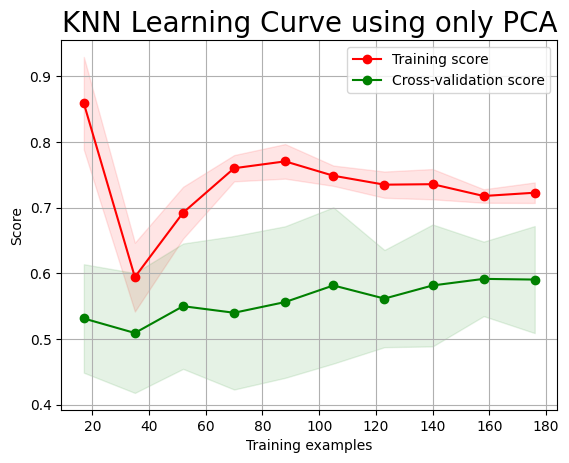

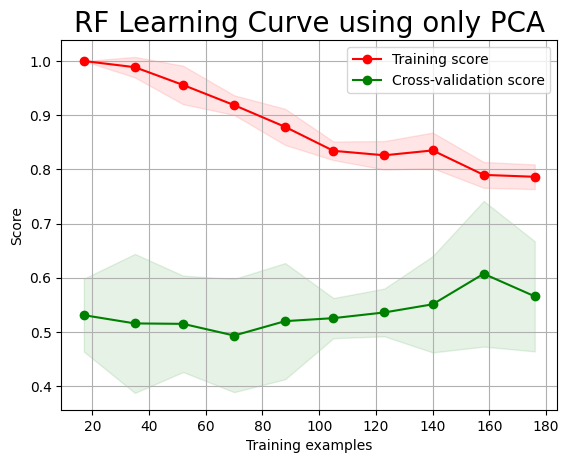

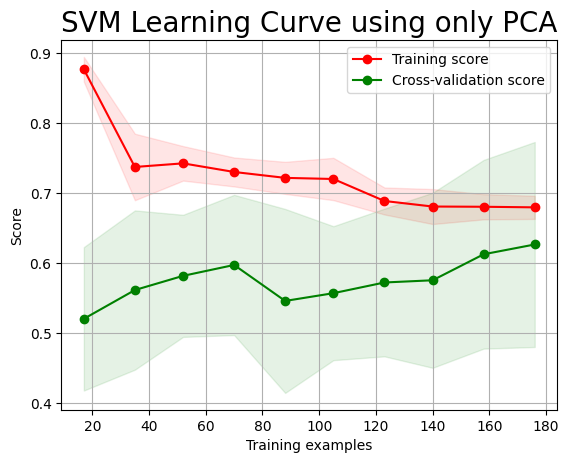

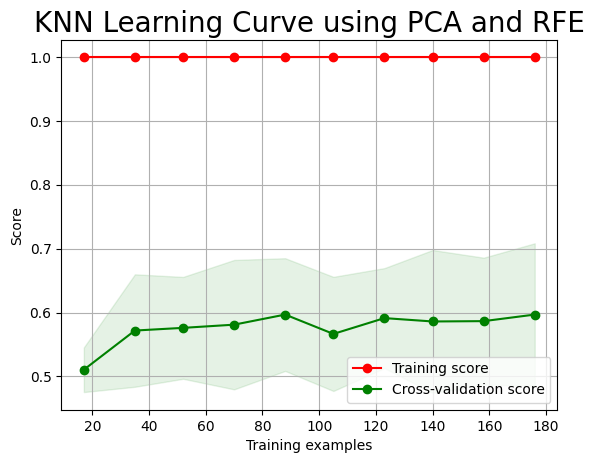

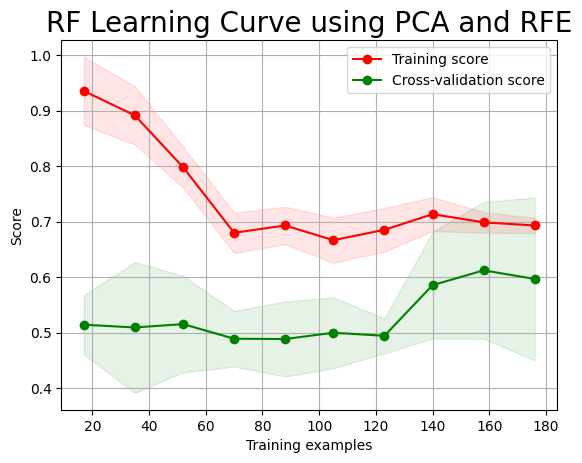

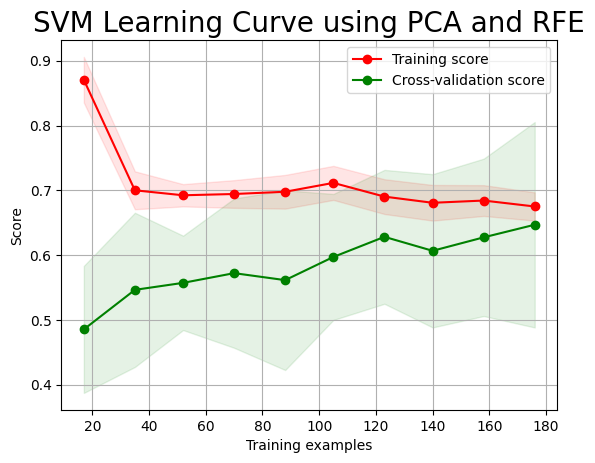

In [ ]:
### Function
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=cv_10fold,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title, fontsize = fontsize)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


### Generate plots
plot_learning_curve(best_estimator_knn, "KNN Learning Curve using only PCA", X_train_pca, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

plot_learning_curve(best_estimator_rf, "RF Learning Curve using only PCA", X_train_pca, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

plot_learning_curve(best_estimator_svm, "SVM Learning Curve using only PCA", X_train_pca, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

plot_learning_curve(best_estimator_knn_rfe, "KNN Learning Curve using PCA and RFE", X_train_rfe, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

plot_learning_curve(best_estimator_rf_rfe, "RF Learning Curve using PCA and RFE", X_train_rfe, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

plot_learning_curve(best_estimator_svm_rfe, "SVM Learning Curve using PCA and RFE", X_train_rfe, y_train, axes=plt.gca(), cv=cv_10fold)
plt.show()

### **Plot cross validation ROC-curves for best estimators**

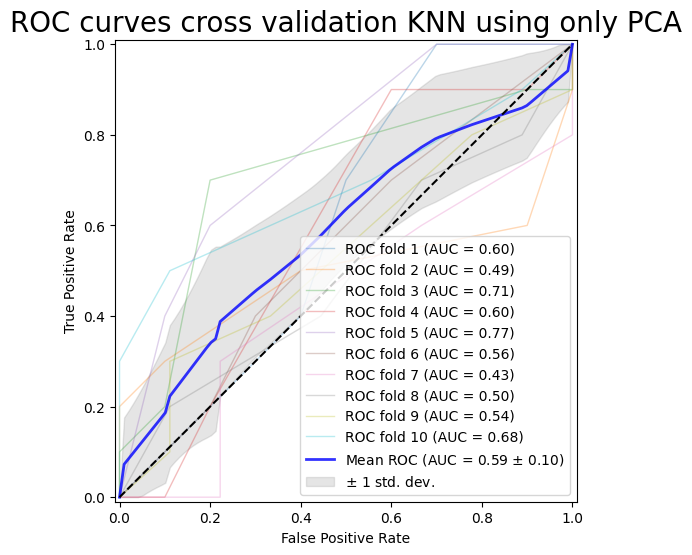

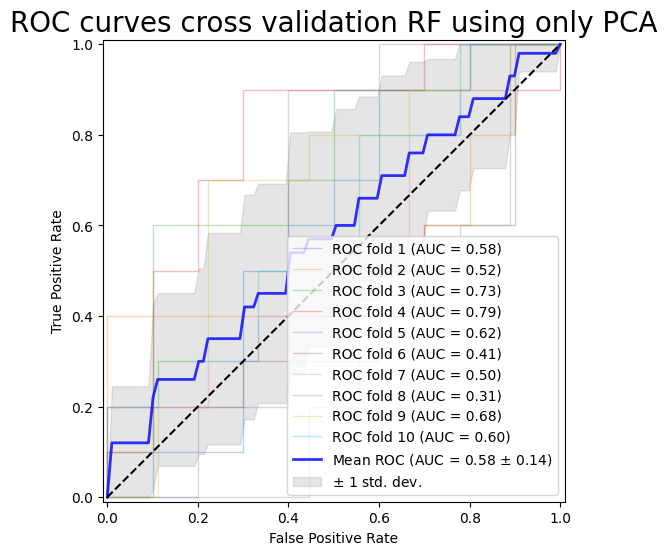

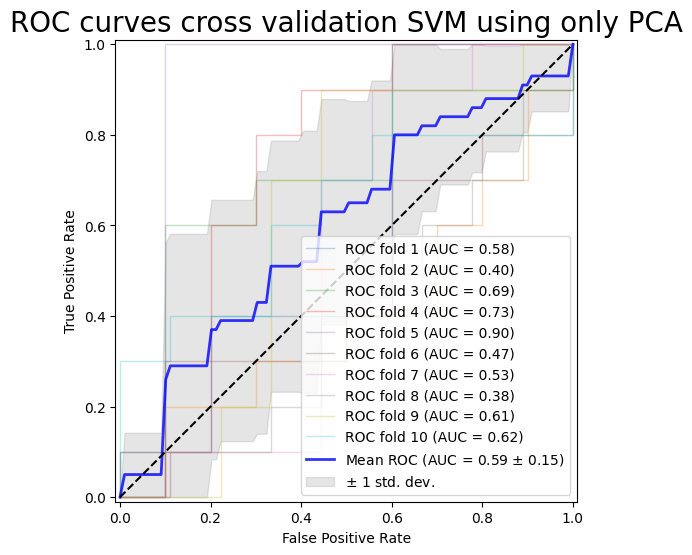

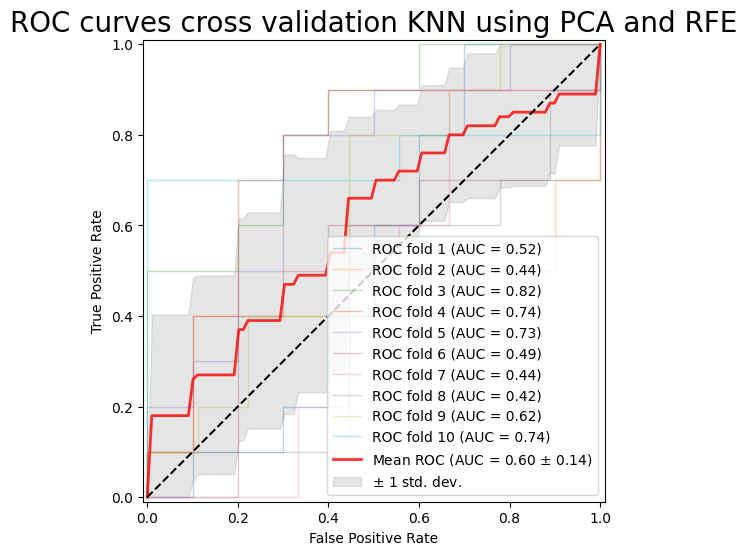

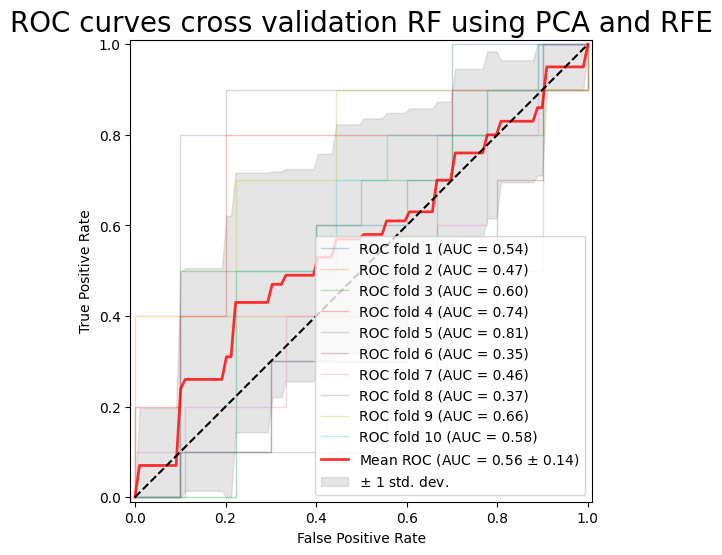

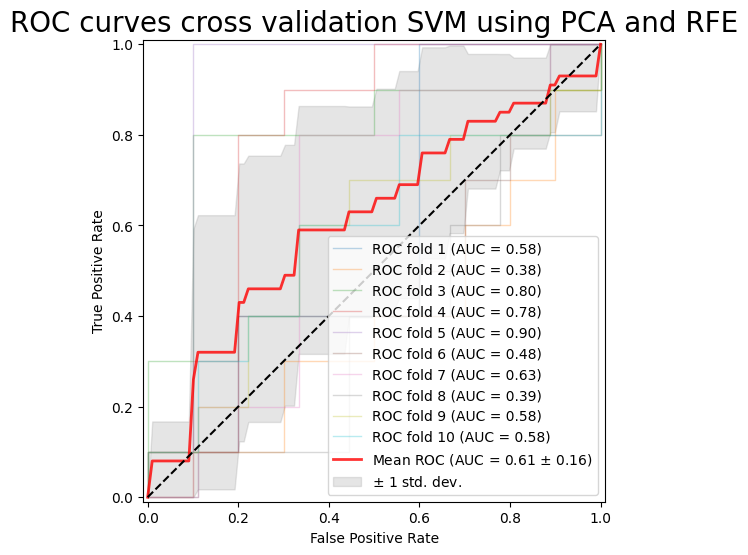

In [ ]:
n_splits = 10
cv = model_selection.StratifiedKFold(n_splits=10)

### For PCA only

clfs = [best_estimator_knn, best_estimator_rf, best_estimator_svm]
titles = ['KNN', 'RF', 'SVM']

# Run classifier with cross-validation and plot ROC curves
for classifier, titles in zip(clfs,titles):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots(figsize=(6, 6))
  for fold, (train, test) in enumerate(cv.split(X_train_pca, y_train)):
      classifier.fit(X_train_pca[train], y_train[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X_train_pca[test],
          y_train[test],
          name=f"ROC fold {fold+1}",
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.plot([0, 1], [0, 1], color='black', linestyle='--')


  ax.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",

      )
  ax.set_title(
    f"ROC curves cross validation {titles} using only PCA",
    fontsize=fontsize
    )
  ax.legend(loc="lower right")
  plt.show()

### For PCA and RFE
n_splits = 10
cv = model_selection.StratifiedKFold(n_splits=10)
clfs = [best_estimator_knn_rfe, best_estimator_rf_rfe, best_estimator_svm_rfe]
titles = ['KNN', 'RF', 'SVM']

# Run classifier with cross-validation and plot ROC curves
for classifier, titles in zip(clfs,titles):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots(figsize=(6, 6))
  for fold, (train, test) in enumerate(cv.split(X_train_rfe, y_train)):
      classifier.fit(X_train_rfe[train], y_train[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X_train_rfe[test],
          y_train[test],
          name=f"ROC fold {fold+1}",
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="r",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.plot([0, 1], [0, 1], color='black', linestyle='--')


  ax.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate"
      )
  ax.set_title(
    f"ROC curves cross validation {titles} using PCA and RFE",
    fontsize=fontsize
    )
  ax.legend(loc="lower right")
  plt.show()

### **Plot ROC-curves for test set performance**

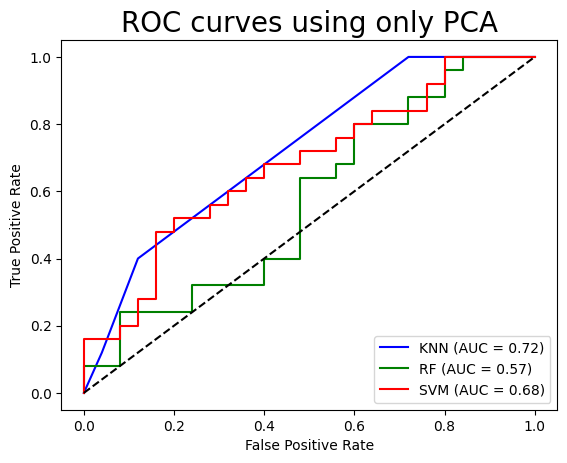

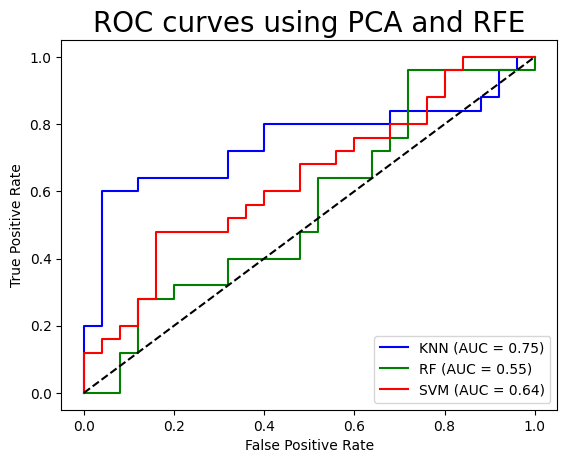

In [ ]:
#For PCA only
y_pred_KNN = grid_search_knn.predict_proba(X_test_pca)[::,1]

y_pred_RF = grid_search_rf.predict_proba(X_test_pca)[::,1]

y_score_SVM = grid_search_svm.decision_function(X_test_pca)

#For PCA and RFE
y_pred_KNN_rfe = grid_search_knn_rfe.predict_proba(X_test_rfe)[::,1]

y_pred_RF_rfe = grid_search_rf_rfe.predict_proba(X_test_rfe)[::,1]

y_score_SVM_rfe = grid_search_svm_rfe.decision_function(X_test_rfe)

## Compute ROC curve and ROC area for each classifier

#For PCA only
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_pred_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

fpr_SVM, tpr_SVM, _ = roc_curve(y_test,  y_score_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

#For PCA and RFE
fpr_KNN_rfe, tpr_KNN_rfe, _ = roc_curve(y_test, y_pred_KNN_rfe)
roc_auc_KNN_rfe = auc(fpr_KNN_rfe, tpr_KNN_rfe)

fpr_RF_rfe, tpr_RF_rfe, _ = roc_curve(y_test, y_pred_RF_rfe)
roc_auc_RF_rfe = auc(fpr_RF_rfe, tpr_RF_rfe)

fpr_SVM_rfe, tpr_SVM_rfe, _ = roc_curve(y_test,  y_score_SVM_rfe)
roc_auc_SVM_rfe = auc(fpr_SVM_rfe, tpr_SVM_rfe)

# Plot ROC curves for all classifiers using only PCA
plt.figure()

plt.plot(fpr_KNN, tpr_KNN, color='blue', label='KNN (AUC = %0.2f)' % roc_auc_KNN)
plt.plot(fpr_RF, tpr_RF, color='green', label='RF (AUC = %0.2f)' % roc_auc_RF)
plt.plot(fpr_SVM, tpr_SVM, color='red', label='SVM (AUC = %0.2f)' % roc_auc_SVM)

# Add labels and legend
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves using only PCA', fontsize = fontsize)
plt.legend(loc="lower right")
plt.show()


# Plot ROC curves for all classifiers using PCA and RFE
plt.figure()

plt.plot(fpr_KNN_rfe, tpr_KNN_rfe, color='blue', label='KNN (AUC = %0.2f)' % roc_auc_KNN_rfe)
plt.plot(fpr_RF_rfe, tpr_RF_rfe, color='green', label='RF (AUC = %0.2f)' % roc_auc_RF_rfe)
plt.plot(fpr_SVM_rfe, tpr_SVM_rfe, color='red', label='SVM (AUC = %0.2f)' % roc_auc_SVM_rfe)

# Add labels and legend
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves using PCA and RFE', fontsize = fontsize)
plt.legend(loc="lower right")
plt.show()

### **Generate table with best estimators**

In [ ]:
names = ['KNN', 'RF', 'SVM', 'KNN with RFE', 'RF with RFE', 'SVM with RFE']
estimators = [best_estimator_knn, best_estimator_rf, best_estimator_svm,
              best_estimator_knn_rfe, best_estimator_rf_rfe, best_estimator_svm_rfe]

df1 = pd.DataFrame(data={'names':names, 'best settings':estimators})

df1.to_excel('table.xlsx')